# CLASSIFICATION TREE
The goal is to create a model that predicts the value of a target variable based on several input variables. 

Each "interior" node of a tree corresponds to one of the input variables; there are edges to children for each of the possible values of that input variable. Each leaf represents a value of the target variable given the values of the input variables represented by the path from the root to the leaf.

A tree can be "learned" by splitting the source set into subsets based on an attribute value test. The "recursion" is completed when the subset at a node has all the same value of the target variable, or when splitting no longer adds value to the predictions (greedy algo).

As any multiway split may be summerized as a series of binary splits, the focus will be made on binary splits.

Splits are obtained by choosing a test at each step that "best" splits the set of items : What does mean Choosing the "best"  split $ S = S_r \cup S_l $ such that $ S_r \cup S_l = \emptyset $ for e test property $T$ ? An obvious heuristic is to choose the the query that decreases the impurity a much as possible.

## Metrics choice
### Gini impurity
Gini Impurity of a set **S** of cardinal *N* measures the probability that a randomly chosen element of the set would be incorrectly labeled if randomly labeled according to the label disytibution in __S__.
$$ GI(S) = \sum_{k=1}^K P(y=k).P(y\neq k) = \sum_{k=1}^K P(y=k)[1-P(y\neq k)] = 1- \sum_{k=1}^K P^2(y=k)$$
then 
$$ \Delta GI(S) = GI(S) - P(S_l)GI(S_l) - (1-P(S_l))GI(S_r) $$
where $P(S_l) = \frac{N_l}{N}$ and $N_l + N_r = N$

### Entropy (Information)  impurity
$$ H(S) = -\sum_{k=1}^K P(y=k) \log_2 P(y=k) $$
the the information gain ($IG$) associated to the split (or partition)  $(S_l,S_r)$ is
$$ IG(S) = H(S) - H(S|(S_l,S_r)) = H(S) - P(S_l)H(S_l) - P(S_r)H(S_r)$$
where $H(S_l)$ (resp $H(S_r)$) are evaluated by using the empirical probabilities of the classes estimated from the subset $S_l$ (resp $S_r$)  : 
$$H(S_l) = -\sum_{k=1}^K P(y=k|X \in S_l) \log_2 P(y=k|X \in S_l)$$

### Misclassification impurity
$$ MI(N) = 1-{\rm max}_kP(y=k) $$
and hence the gain in MI 
$$ \Delta MI(N) = MI(N) - P(S_l)MI(N_l) -P(S_r)MI(N_r) = MI(N)-1+P(S_l){\rm max}_kP(y=k|X\in S_l)+P(S_r){\rm max}_kP(y=k|X\in S_r)$$
## Splitting strategy
Designers usually choose to split wrt a single attribute. In general for non numerical attributes, an exhasutive search over all possibilities is performed. For real values attribute, gradient method for identifying a separating hyperplane may be used; However, simple threshold on a single attribute is often prefered. 


In [3]:
from sklearn.datasets import load_iris
from sklearn  import tree
import numpy as np
import graphviz 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

iris = load_iris()
nbdepth=3
estimator = tree.DecisionTreeClassifier(max_depth=nbdepth,criterion='entropy')

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print("resp. length of X_train and X_test are {0} and {1} ".format([len(X_train)],[len(X_test)]))

estimator = estimator.fit(X_train, y_train)
estimator

resp. length of X_train and X_test are [112] and [38] 


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

For detailed explanations on the role of each input parameter, refer to 
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier


## Visualize the resulting Tree

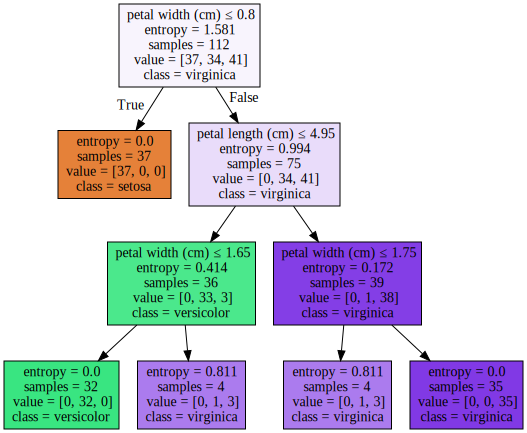

In [2]:

dot_data = tree.export_graphviz(estimator, out_file=None) 
dot_data = tree.export_graphviz(estimator, out_file=None, 
                                feature_names=iris.feature_names,  
                                class_names=iris.target_names,  
                                filled=True,  
                                special_characters=True
                               )  
graph = graphviz.Source(dot_data) 
#graph.render("iris")            #for making a pdf output
graph                           

## Describe the resulting Tree
This part describes the Tree structure obtained, for a better understanding

https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

In [4]:
# The decision estimator has an attribute called tree_  which stores the entire
# tree structure and allows access to low level attributes. The binary tree
# tree_ is represented as a number of parallel arrays. The i-th element of each
# array holds information about the node `i`. Node 0 is the tree's root. NOTE:
# Some of the arrays only apply to either leaves or split nodes, resp. In this
# case the values of nodes of the other type are arbitrary!
#
# Among those arrays, we have:
#   - left_child, id of the left child of the node
#   - right_child, id of the right child of the node
#   - feature, feature used for splitting the node
#   - threshold, threshold value at the node
#

# Using those arrays, we can parse the tree structure:

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

# First let's retrieve the decision path of each sample. The decision_path
# method allows to retrieve the node indicator functions. A non zero element of
# indicator matrix at the position (i, j) indicates that the sample i goes
# through the node j.

node_indicator = estimator.decision_path(X_test)

# Similarly, we can also have the leaves ids reached by each sample.

leave_id = estimator.apply(X_test)

# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.

sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    if leave_id[sample_id] == node_id:
        continue

    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node %s : (X_test[%s, %s] (= %s) %s %s)"
          % (node_id,
             sample_id,
             feature[node_id],
             X_test[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))


The binary tree structure has 9 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 2] <= 2.350000023841858 else to node 2.
	node=1 leaf node.
	node=2 test node: go to node 3 if X[:, 2] <= 4.950000047683716 else to node 6.
		node=3 test node: go to node 4 if X[:, 3] <= 1.6500000357627869 else to node 5.
			node=4 leaf node.
			node=5 leaf node.
		node=6 test node: go to node 7 if X[:, 2] <= 5.049999952316284 else to node 8.
			node=7 leaf node.
			node=8 leaf node.

Rules used to predict sample 0: 
decision id node 0 : (X_test[0, 2] (= 5.1) > 2.350000023841858)
decision id node 2 : (X_test[0, 2] (= 5.1) > 4.950000047683716)
decision id node 6 : (X_test[0, 2] (= 5.1) > 5.049999952316284)


## Plot the result of the obtained Tree Classifier for the Training and Test sets respectively.

y_est from  X_test data :
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 2]
y_est from  X_train data :
[1 1 2 0 2 0 0 1 2 2 2 2 1 2 1 1 2 2 2 2 1 2 1 0 2 1 1 1 1 2 0 0 2 1 0 0 1
 0 2 1 0 1 2 1 0 2 2 2 2 0 0 2 2 0 2 0 2 2 0 0 2 0 0 0 1 2 2 0 0 0 1 1 0 0
 1 0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 1 2 0 1 2 2 0 1 1 2 1 0 0 0 2 1 2
 0]


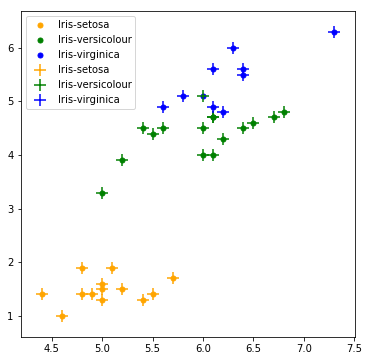

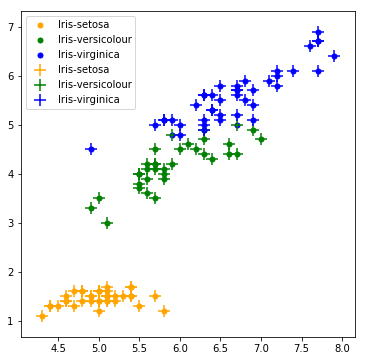

In [5]:
#Visualising the clusters wrt axes x1, x3 on train set
y_est=estimator.predict(X_test)
print("y_est from  X_test data :")
print(y_est) 
x=X_test

plt.figure(figsize=(6,6))
plt.scatter(x[y_est == 0, 0], x[y_est == 0, 2], s = 25, c = 'orange',label = 'Iris-setosa')
plt.scatter(x[y_est == 1, 0], x[y_est == 1, 2], s = 25, c = 'green', label = 'Iris-versicolour')
plt.scatter(x[y_est == 2, 0], x[y_est == 2, 2], s = 25, c = 'blue', label = 'Iris-virginica')
plt.scatter(x[y_test == 0, 0], x[y_test == 0, 2], marker='+', s = 155, c = 'orange',label = 'Iris-setosa')
plt.scatter(x[y_test == 1, 0], x[y_test == 1, 2], marker='+', s = 155, c = 'green', label = 'Iris-versicolour')
plt.scatter(x[y_test == 2, 0], x[y_test == 2, 2], marker='+', s = 155, c = 'blue', label = 'Iris-virginica')
plt.legend()

#Visualising the clusters wrt axes x1, x3 on test set
y_est=estimator.predict(X_train)
print("y_est from  X_train data :")
print(y_est)
x=X_train
plt.figure(figsize=(6,6))
plt.scatter(x[y_est == 0, 0], x[y_est == 0, 2], s = 25, c = 'orange',label = 'Iris-setosa')
plt.scatter(x[y_est == 1, 0], x[y_est == 1, 2], s = 25, c = 'green', label = 'Iris-versicolour')
plt.scatter(x[y_est == 2, 0], x[y_est == 2, 2], s = 25, c = 'blue', label = 'Iris-virginica')
plt.scatter(x[y_train == 0, 0], x[y_train == 0, 2], marker='+', s = 155, c = 'orange',label = 'Iris-setosa')
plt.scatter(x[y_train == 1, 0], x[y_train == 1, 2], marker='+', s = 155, c = 'green', label = 'Iris-versicolour')
plt.scatter(x[y_train == 2, 0], x[y_train == 2, 2], marker='+', s = 155, c = 'blue', label = 'Iris-virginica')
#Plotting the centroids of the clusters
plt.legend()

## Compute the corresponding Confusion matrices

In [6]:
from sklearn import metrics

y_est=estimator.predict(X_train)
print("Confusion matrix from training set :")
print("{}".format(metrics.confusion_matrix(y_est,y_train)))
print("accuracy= {}".format(metrics.accuracy_score(y_est,y_train)))

y_est=estimator.predict(X_test)
print("Confusion matrix from test set :")
print("{}".format(metrics.confusion_matrix(y_est,y_test)))
print("accuracy= {}".format(metrics.accuracy_score(y_est,y_test)))

Confusion matrix from training set :
[[37  0  0]
 [ 0 32  0]
 [ 0  2 41]]
accuracy= 0.9821428571428571
Confusion matrix from test set :
[[13  0  0]
 [ 0 15  0]
 [ 0  1  9]]
accuracy= 0.9736842105263158


## Evaluate the score of the Classification Tree approach, using cross validation

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
scores = cross_val_score(estimator, iris.data, iris.target, cv=cv)
print("Mean Accuracy and 95 percent confidence interval : %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() *2))


Mean Accuracy and 95 percent confidence interval : 0.96 (+/- 0.07)


# RANDOM FOREST
**"Random forest"** is an **ensemble** methods. Its goal is to **combine** the predictions of several base estimators built with a given learning algorithm (Tree classifier in our example) **in order to improve generalizability / robustness** over a single estimator.

Two families of ensemble methods are usually distinguished:
The **driving principle** is to build several estimators **independently** and then to average (for regression) or to combine (majority vote for classification) their predictions. The combined estimator is expected to be usually better than any of the single base estimator because its **variance is reduced**.

Among the most popular examples, one finds Bagging methods, Forests of randomized trees, …

Another class of methods, refered to as boosting methods, builts base estimators sequentially and while trying to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble (Examples: AdaBoost, Gradient Tree Boosting, …).

More details and references here: https://scikit-learn.org/stable/modules/ensemble.html#forest

#### RandomForestClassifier or RandomForestRegressor : 
a. Each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. 

b. When splitting a node during the construction of the tree, the split that is chosen is **no longer the best split among all features but the best split among a random subset of the features**. As a result of this randomness, the **bias** of the forest usually **slightly increases** but, due to averaging, its **variance also decreases**, hence yielding an overall better model.

Notice : In contrast to the original publication [B2001], the scikit-learn implementation combines classifiers by averaging their probabilistic prediction, instead of letting each classifier vote for a single class.

##### Randomized Trees
ExtraTreesClassifier and ExtraTreesRegressor :  randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=0, criterion='entropy')
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print("Mean Accuracy and 95 percent confidence interval RandomForest: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() *2)) 

clf = ExtraTreesClassifier(n_estimators=100, max_depth=None, random_state=0, criterion='entropy')
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print("Mean Accuracy and 95 percent confidence interval ExtraTrees: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() *2))  

Mean Accuracy and 95 percent confidence interval RandomForest: 0.97 (+/- 0.07)
Mean Accuracy and 95 percent confidence interval ExtraTrees: 0.96 (+/- 0.09)


[0.09836612 0.06538735 0.24477374 0.23396088]
Feature ranking:
1. feature 3 (0.434966)
2. feature 2 (0.420399)
3. feature 0 (0.081114)
4. feature 1 (0.063521)


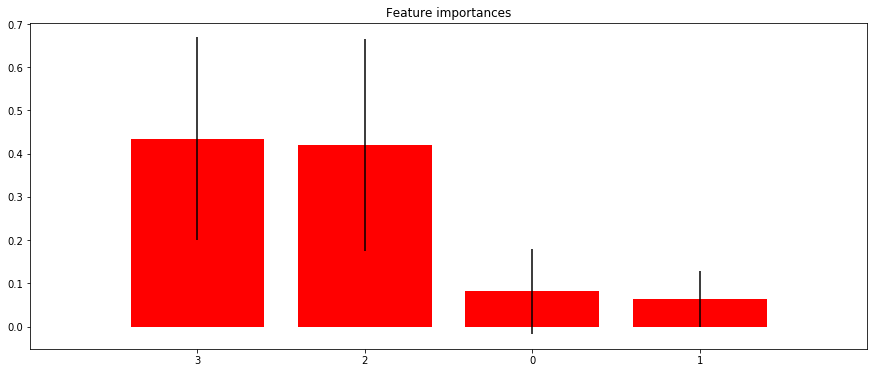

In [8]:
clf.fit(iris.data, iris.target)
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
print(std)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(np.asarray(iris.data).shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    # Plot the feature importances of the forest
plt.figure(figsize=(15,6))
plt.title("Feature importances")
plt.bar(range(np.asarray(iris.data).shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks( range( np.asarray(iris.data).shape[1]) , indices)
plt.xlim([-1, np.asarray(iris.data).shape[1]])

plt.show()



## AdaBoost classifier.
An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where **the weights of incorrectly classified instances** are adjusted such that subsequent classifiers focus more on difficult cases.
Boosting bears a resemblance to Bagging (e.g. Random Forest), but is rather different, as it consists in a sequential improvement of a weak classification algorithm, applied to repeatedly modified versions of the data. It produces a a sequence of weak classifiers, ther prediction of which are then combined through a weighted majority vote. 
A sketch of the AdaBoost algo is 

1. initialize all sample weights $w_i=\frac{1}{N}$, for $i=1\ldots N$

2. for $m=1$ to $M$:
    1. Fit a classifier $G_m(X)$ to train data using $\{w_i\}$
    2. Compute
    $$ err_m = \frac{\sum_{i=1}^N w_i {\cal I}(y_i\neq G_m(X_i))}{\sum_i w_i}$$
    3. Compute $\alpha_m = \log(1/err_m -1)$
    4. set $w_i \leftarrow w_i\exp{[\alpha_m{\cal I}(y_i\neq G_m(X_i))]}$, $ii=1\ldots N$
3. Output $$G(X) = {\rm sign} \left[ \sum_{m=1}^M \alpha_m G_m(X) \right]$$
    
The algorithm above is known as AdaBoost.M1 or "Discrete AdaBoost", because $G_m(X)$ returns discrete class labels. If $G_m(X)$ returns real valued labels (e.g. probability), AdaBosst can be modified appropriatly, to become "Real AdaBoost". 

Details in:

Friedman et al, 2000 : *Annals of Statistics*, **28**:307-337.

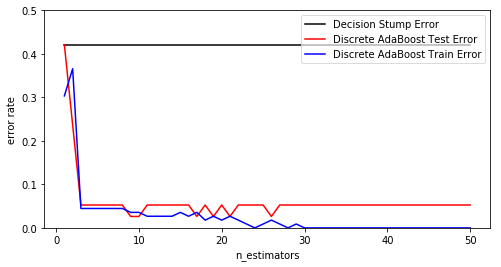

Mean Accuracy and 95 percent confidence interval AdaBoost: 0.95 (+/- 0.13)


In [9]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import zero_one_loss

n_estimators = 50
# A learning rate of 1. may not be optimal for both SAMME and SAMME.R
learning_rate = 1.

dt_stump = tree.DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)  # comment this tree!
dt_stump.fit(X_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)

ada_discrete = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME")
ada_discrete.fit(X_train, y_train)


fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_stump_err] * 2, 'k-',
        label='Decision Stump Error')

ada_discrete_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
    ada_discrete_err[i] = zero_one_loss(y_pred, y_test)
    
ada_discrete_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
    ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train)


ax.plot(np.arange(n_estimators) + 1, ada_discrete_err,
        label='Discrete AdaBoost Test Error',
        color='red')
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err_train,
        label='Discrete AdaBoost Train Error',
        color='blue')

ax.set_ylim((0.0, 0.5))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

scores = cross_val_score(ada_discrete, iris.data, iris.target, cv=10)
print("Mean Accuracy and 95 percent confidence interval AdaBoost: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() *2)) 

